# Библиотеки

In [1]:
!pip install sprt

  Preparing metadata (setup.py) ... done
  Created wheel for sprt: filename=sprt-0.0.1-py3-none-any.whl size=4018 sha256=e8aa98aee961a73de74ccddc883a58b862e8cd34d7507d7a7ae181a3aa9253c8
  Stored in directory: /root/.cache/pip/wheels/57/4f/5e/0ccefece378c1aac79f5e3093849173236b19f3781e070ab03
Successfully built sprt


In [2]:
from zlib import crc32

import numpy as np
import pandas as pd
import scipy.stats as st

from pandas import read_csv
from sprt import SPRTBinomial
from scipy.optimize import root_scalar
from functools import partial
from numpy import log
from math import floor
from IPython.display import clear_output

# Код генерации выборки

In [3]:
import re
EMAIL_REGEX = re.compile(r"[^@]+@phystech.edu")

def generate_dataset(code):
    rs = np.random.RandomState(code)
    proba = 0.01 * rs.randint(low = 55, high = 70)
    return 1.0*(rs.uniform(size = 5000) < proba)

# Генерация выборки для вашей почты

<span style="color:red">
    ВАЖНО!
    Почта, которую укажете ниже и почта с которой Вы отправляете домашнее задание должна совпадать!
    В момент проверки задания алгоритм генерирует выборку на основе почты из анкеты!
</span>

Внимательно проверьте почту для которой выполняется задание!

In [4]:
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
assert EMAIL_REGEX.match(task['mail']), 'Not a mail in the phystech.edu domain'
task['id'] = crc32(task['mail'].encode('utf-8'))
task['data'] = generate_dataset(task['id'])

task

Enter your mail: egorov.sa@phystech.edu


{'mail': 'egorov.sa@phystech.edu',
 'id': 1581189463,
 'data': array([1., 1., 1., ..., 1., 1., 1.])}

# Работа с выборкой

In [5]:
df = pd.DataFrame(task['data'])
df.describe()

,0
count,5000.000000
mean,0.582000
std,0.493279
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

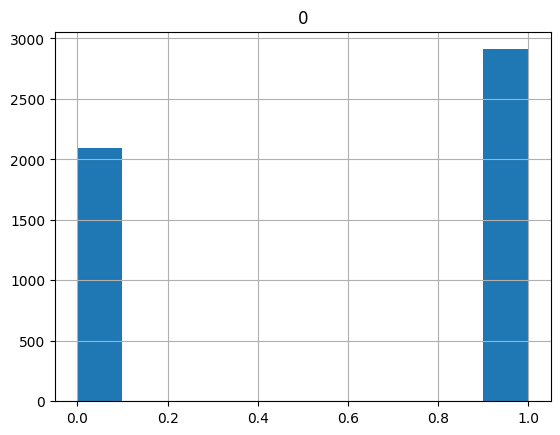

In [6]:
df.hist()

# Задание

## Вопрос 1
Оценка вероятности методом максимального правдоподобия. (Ответ округлите до 3-х знаков после запятой).

In [7]:
p = len(df[df[0] == 1]) / len(df)
print(f'p = {p:.3}')

p = 0.582


## Вопрос 2
С помощью последовательного анализа проверить нулевую гипотезу $p_0=0.5$ против $p_1$, полученной методом максимального правдоподобия. Использовать библиотеку `sprt` с $\alpha=\beta=0.05$. Гипотеза принимается?

Decision:	Reject

      values     lower     upper
n                               
4991  2905.0  2692.164  2709.956
4992  2905.0  2692.705  2710.497
4993  2906.0  2693.246  2711.038
4994  2906.0  2693.788  2711.579
4995  2906.0  2694.329  2712.121
4996  2907.0  2694.870  2712.662
4997  2908.0  2695.411  2713.203
4998  2909.0  2695.952  2713.744
4999  2910.0  2696.494  2714.285
5000     NaN  2697.035  2714.827


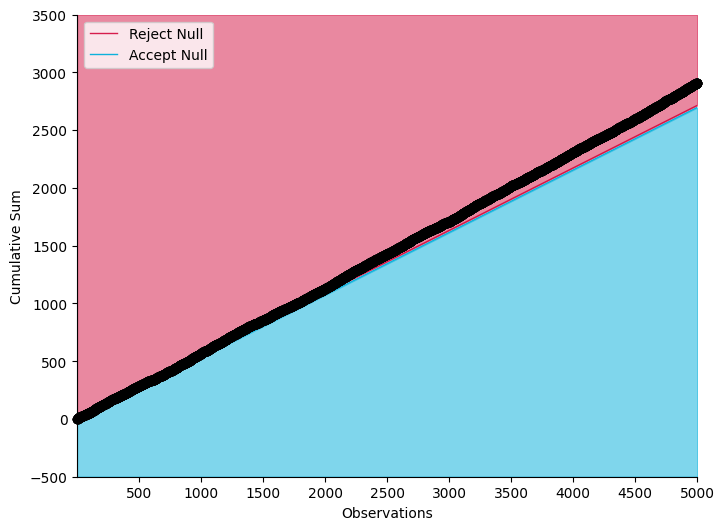

In [8]:
alpha = beta = 0.05

test = SPRTBinomial(alpha=alpha, beta=beta, h0=0.5, h1=p, values=df[0])
test.plot()

In [14]:
print(f'We {test.decision.lower()} the null hypothesis')

We reject the null hypothesis


## Вопрос 3
Какое минимальное количество итераций требуется для вынесения решения по данной гипотезе?

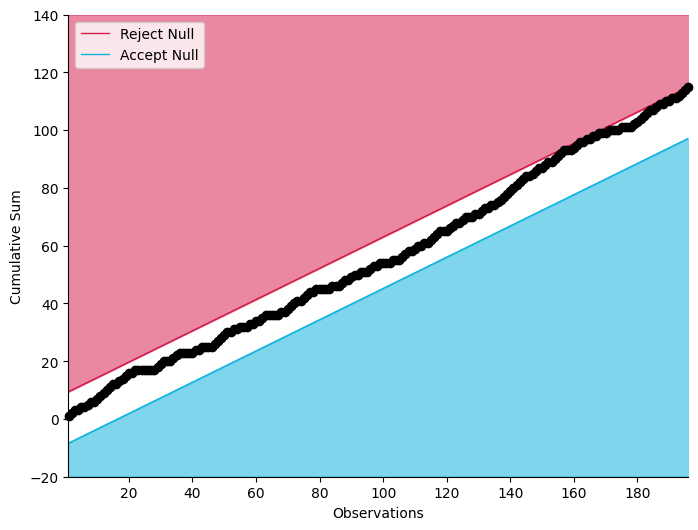


 Гипотеза отклоняется за 197 итераций


In [10]:
i = 50
test = SPRTBinomial(alpha=alpha, beta=beta, h0=0.5, h1=p, values=df[0][:i])

while test.decision != 'Reject':
    test = SPRTBinomial(alpha=alpha, beta=beta, h0=0.5, h1=p, values=df[0][:i])
    i += 1
# Это сделано чтобы убрать нафиг ненужные таблицы.
clear_output(wait=True)

test.plot()
print(f'\n Гипотеза отклоняется за {i} итераций')

## Вопрос 4
Матождиание требуемого количества итераций (для решения уравнения со слайдов можно использовать `scipy.optimize.root_scalar`). За истинное значение параметра принимать МП-оценку. Округлять до целого числа в меньшую сторону.

In [11]:
def expectation(p, p_0, alpha, beta, h):
    A = (1 - beta) / alpha
    B = beta / (1 - alpha)
    L = (A ** h - 1) / (A ** h - B ** h)

    result = (L * log(B) + (1 - L) * log(A)) / (p * log(p / p_0) + (1 - p) * log((1 - p)/(1 - p_0)))
    return result

def f(x, p, p_0):
    return (1 - ((1 - p) / (1 - p_0))**x) / ((p / p_0)**x - ((1 - p) / (1 - p_0))**x) - p

In [12]:
p = len(df[df[0] == 1]) / len(df)
p_0 = 0.5
alpha = 0.05
beta = 0.05

f_new = partial(f, p=p, p_0=p_0)

sol = root_scalar(f_new, bracket=[-10, 10], method='brentq')
print(f'{sol}')
h = sol.root
print(f'\nExpectation of the iterations count: {floor(expectation(p, p_0, alpha, beta, h))}')

      converged: True
           flag: converged
 function_calls: 8
     iterations: 7
           root: -1.0000000000003528

Expectation of the iterations count: 196
